<a href="https://colab.research.google.com/github/RodrigoRS11/DIO-desafioBairesdev-recommendationSystem/blob/main/DIO_desafioBairesdev_recomendacaoProdutos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Carregar modelo pré-treinado sem as camadas de classificação (topo)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congelar as camadas do modelo pré-treinado


In [2]:
# Adicionar novas camadas após a base
x = base_model.output
x = GlobalAveragePooling2D()(x)  # A média global das características extraídas
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # 4 classes

# Criar o modelo final
model = Model(inputs=base_model.input, outputs=predictions)


In [3]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

train_generator = train_datagen.flow_from_directory('/content/sample_data/dataset', target_size=(224, 224),
                                                    batch_size=32, class_mode='categorical')

print(train_generator.class_indices)



Found 75 images belonging to 4 classes.
{'bolsas': 0, 'camisetas': 1, 'relogios': 2, 'sapatos': 3}


In [5]:
# Treina inicialmente apenas as camadas personalizadas (sem fine-tuning)
model.fit(train_generator, epochs=10, steps_per_epoch=100)

# Desbloqueia camadas da base para fine-tuning
base_model.trainable = True  # Torna a base treinável

fine_tune_at = 100  # Defina a partir de qual camada as atualizações ocorrerão
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False  # Congela as camadas anteriores

# Recompila o modelo com uma taxa de aprendizado menor para fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Continua o treinamento após recompilar
model.fit(train_generator, epochs=10, steps_per_epoch=100)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.3587 - loss: 1.6129  
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9337 - loss: 0.2271   
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9461 - loss: 0.1844
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 1.0000 - loss: 0.0132   
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 1.0000 - loss: 0.0013   
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9864 - loss: 0.0147
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 1.0000 - loss: 9.2440e-04
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 1.0000 - loss: 0.0037
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 1.0000 - loss: 0.0056
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 1.0000 - loss: 4.3393e-04
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.7585 - loss: 0.8372
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8273 - loss: 0.5927
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━

In [6]:
# Salvar o modelo completo em um arquivo .h5
model.save('meu_modelo.h5')


In [7]:
# Salvar apenas os pesos do modelo
model.save_weights('model_weights.weights.h5')


In [8]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Carregar e pré-processar a imagem
img = image.load_img('/content/sample_data/teste3.jpg', target_size=(224, 224))  # Ajuste o tamanho conforme o modelo
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Adiciona a dimensão do batch

# Normalizar a imagem (caso tenha sido feito no pré-processamento do modelo)
img_array = img_array / 255.0

# Fazer a previsão
predictions = model.predict(img_array)

# Ver as classes previstas
predicted_class = np.argmax(predictions, axis=1)  # A classe com a maior probabilidade
print(f"A classe prevista é: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
A classe prevista é: [3]


In [9]:
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.preprocessing import image

# Remover a camada final de classificação e pegar a saída da penúltima camada
embedding_model = Model(inputs=model.input, outputs=model.layers[-2].output)

# Função para gerar embeddings de uma imagem
def get_image_embedding(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Ajuste o tamanho conforme necessário
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Adiciona a dimensão do batch
    img_array = img_array / 255.0  # Normalizar a imagem (se necessário)

    # Gerar o embedding (vetor de características) da imagem
    embedding = embedding_model.predict(img_array)
    return embedding.flatten()  # Retorna como um vetor unidimensional


In [10]:
import os

# Pasta onde estão as imagens
image_dir = '/content/sample_data/dataset'

# Lista para armazenar os embeddings das imagens e seus caminhos
embeddings = []
image_paths = []

# Iterar por cada subpasta (bolsas, camisetas, etc.)
for subdir in os.listdir(image_dir):
    subdir_path = os.path.join(image_dir, subdir)

    # Verificar se é uma subpasta (não arquivo)
    if os.path.isdir(subdir_path):
        for img_name in os.listdir(subdir_path):
            img_path = os.path.join(subdir_path, img_name)

            # Verificar se é um arquivo de imagem (você pode ajustar a extensão conforme necessário)
            if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                embedding = get_image_embedding(img_path)
                embeddings.append(embedding)
                image_paths.append(img_path)

print(f"Total de imagens processadas: {len(embeddings)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


In [32]:
from sklearn.metrics.pairwise import cosine_similarity

# Calcular a similaridade entre a imagem de consulta e todas as imagens
def recommend_similar_images(query_img_path, embeddings, image_paths, top_k=3):
    query_embedding = get_image_embedding(query_img_path)

    # Calcular a similaridade cosseno entre o embedding da consulta e todos os embeddings
    similarities = cosine_similarity([query_embedding], embeddings)

    # Obter os índices das imagens mais semelhantes
    similar_indices = similarities[0].argsort()[-top_k:][::-1]

    # Retornar as imagens mais semelhantes
    similar_images = [image_paths[i] for i in similar_indices]

    return similar_images

# Testar o sistema de recomendação com uma imagem de consulta
query_img_path = '/content/sample_data/teste10.jpg'
similar_images = recommend_similar_images(query_img_path, embeddings, image_paths)

print("Imagens recomendadas:")
for img in similar_images:
    print(img)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Imagens recomendadas:
/content/sample_data/dataset/relogios/3.jpg
/content/sample_data/dataset/relogios/11.jpg
/content/sample_data/dataset/relogios/6.jpg


Imagem de busca:


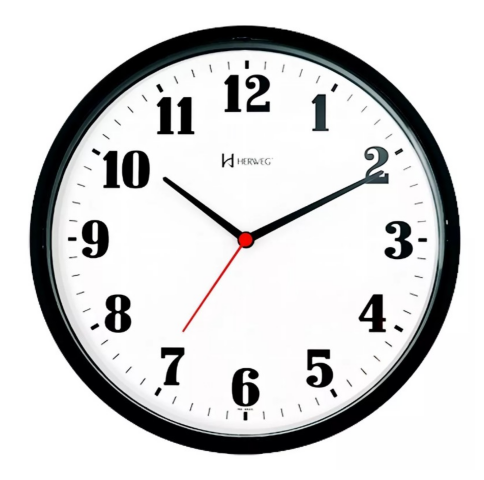

Imagens recomendadas:


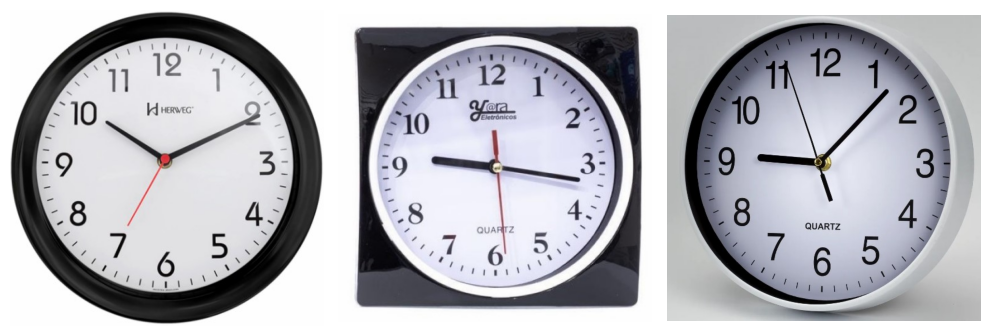

In [33]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# imagem de busca
img_path = query_img_path  # Substitua pelo caminho correto da sua imagem

print("Imagem de busca:")

# Carregar e exibir a imagem
img = mpimg.imread(img_path)
plt.figure(figsize=(6, 6))  # Ajuste o tamanho da figura conforme necessário
plt.imshow(img)
plt.axis('off')  # Remove os eixos X e Y
plt.show()

print("Imagens recomendadas:")

# Exibir as imagens recomendadas (sem eixos X e Y)
plt.figure(figsize=(10, 10))  # Ajuste o tamanho da figura conforme necessário

# Definir o número de colunas e linhas para a exibição das imagens
num_images = len(similar_images)
cols = 3  # Número de colunas (ajuste conforme necessário)
rows = (num_images // cols) + (num_images % cols > 0)  # Número de linhas

for i, img_path in enumerate(similar_images):
    # Carregar e exibir cada imagem
    img = mpimg.imread(img_path)
    ax = plt.subplot(rows, cols, i+1)  # Definir o local de cada imagem no grid
    ax.imshow(img)
    ax.axis('off')  # Remove os eixos X e Y

plt.tight_layout()  # Ajusta o layout automaticamente
plt.show()
